In [1]:
import numpy as np
import pandas as pd
import os
import glob
import h5py
import wandb

import string
import random

import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint


from torch import optim, utils, Tensor

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import sklearn.linear_model


from itables import show
from src.model.SimpleMILModels import Attention, MaxMIL, AttentionResNet
from src.dataloaders.DataLoaders import RetCCLFeatureLoader, RetCCLFeatureLoaderMem


import zarr
import seaborn as sns

recompute_attn = False

In [2]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [3]:


import os
os.environ['HTTP_PROXY']="http://www-int.dkfz-heidelberg.de:80"
os.environ['HTTPS_PROXY']="http://www-int.dkfz-heidelberg.de:80"


In [4]:
group = "6X01HP"

In [5]:

api = wandb.Api()


In [6]:
runs = api.runs(path="psmirnov/UKHD_RetCLL_299_CT", filters={"group": group})

In [7]:
runs

<Runs psmirnov/UKHD_RetCLL_299_CT>

Load in the features (not too much memory needed)

In [10]:
path_to_extracted_features = '/home/p163v/histopathology/spatial_medullo/UNI_embeddings/pt'

In [11]:
slide_names = ['1.1','1.2','1.3','2.1','2.2','2.3','3.1','3.4','4.1','4.2','4.3','4.4','5.1','5.2','5.3','5.4']

In [22]:
test_features = [torch.load(path_to_extracted_features + "/" + file + ".pt").numpy() for file in slide_names]

In [23]:
[x.shape for x in test_features]

[(9366, 1024),
 (12771, 1024),
 (9345, 1024),
 (2095, 1024),
 (645, 1024),
 (304, 1024),
 (1401, 1024),
 (6323, 1024),
 (3557, 1024),
 (13051, 1024),
 (3674, 1024),
 (3706, 1024),
 (2192, 1024),
 (5170, 1024),
 (25360, 1024),
 (11410, 1024)]

In [24]:
test_labels = [0 for x in test_features]

# Loss

We use the loss as the early stopping criteria


In [25]:
model_list = list()
attention_list = list()
prob_list = list()
pred_list = list()
cv =  lambda x: np.std(x) / np.mean(x)

In [26]:
test_data = RetCCLFeatureLoaderMem(test_features, np.array(test_labels), patches_per_iter='all')

RetCCLTest = DataLoader(test_data, batch_size=1, num_workers=1)#, sampler=valid_Sampler)


In [27]:
for ii in range(len(runs)):
    
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version).split('-')[0]: a for a in arts}
    checkpoint_folder_name = arts_dict['model'].name.split('-')[1].removesuffix(':'+arts_dict['model'].version)
    args = runs[0].config

    model = Attention(1024, lr=args['lr'], weight_decay=args['weight_decay'], hidden_dim=args['hidden_dim'], attention_dim=args['attention_dim'], class_weights=torch.tensor(float(args['class_weights'])))
    chkpt_file = glob.glob('lightning_logs/'+checkpoint_folder_name+'/checkpoints/best_loss*')[0]
    model = model.load_from_checkpoint(chkpt_file, map_location=torch.device('cpu'))
    model.eval()
    model_list.append(model)
    model_forward = [model.forward(x.to(model.device)) for x,y in iter(RetCCLTest)]
    model_attention = [x[2].detach().numpy() for x in model_forward]
    model_prob = [x[0].detach().numpy() for x in model_forward]
    model_pred = [x[1].detach().numpy() for x in model_forward]

    attention_list.append(model_attention)
    prob_list.append(model_prob)
    pred_list.append(model_pred)
    

In [30]:
prob_list = [np.concatenate(x) for x in prob_list]
pred_list = [np.concatenate(x) for x in pred_list]


In [81]:
pred_list

[array([0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       dtype=float32),
 array([0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       dtype=float32),
 array([0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)]

In [79]:
pred_test = np.mean(np.vstack(pred_list), axis=0)

In [80]:
pred_test

array([False, False,  True, False,  True,  True, False,  True, False,
       False, False, False, False, False, False, False])

In [74]:
prob_test = np.mean(np.vstack(prob_list), axis=0)

In [43]:
# prob_test = np.mean(np.vstack([sigmoid_array(x) for x in prob_list]), axis=0)





Lets load in the real test labels.

In [47]:
human_sample_map = {
    "1.1": 1,
    "1.2": 1,
    "1.3": 1,
    "3.4": 1,
    "2.1": 1,
    "2.2": 1,
    "2.4": 1,
    "3.1": 1,
    "4.1": 0,
    "4.3": 0,
    "5.2": 0,
    "5.3": 0,
    "5.4": 0
}


In [50]:
test_labels = [human_sample_map[x] for x in slide_names if x in human_sample_map]

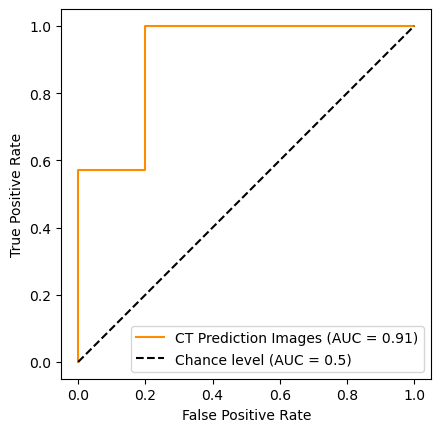

In [75]:


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    np.array(test_labels),
    prob_test[[x in human_sample_map for x in slide_names]],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.savefig("/home/p163v/histopathology/Notebooks/SpatialMedullo_ROC.png")
plt.show()


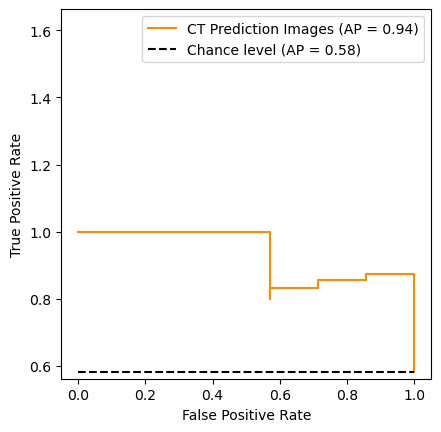

In [76]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    np.array(test_labels),
    prob_test[[x in human_sample_map for x in slide_names]],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.savefig("/home/p163v/histopathology/Notebooks/Spatial_Medullo_Validation_AUPR_UNI.png")
plt.show()

In [64]:
np.array(test_labels)

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [77]:
prob_test[[x in human_sample_map for x in slide_names]]

array([-0.5708208 , -0.8194804 ,  0.6803135 , -0.13930836,  0.48819017,
       -0.6618797 ,  1.6025183 , -2.0573845 , -2.223454  , -0.97018737,
       -2.629653  , -0.20183325], dtype=float32)

In [85]:
prob_test[[x in human_sample_map for x in slide_names]]>-0.2

array([False, False,  True,  True,  True, False,  True, False, False,
       False, False, False])

In [82]:
pred_test[[x in human_sample_map for x in slide_names]]

array([False, False,  True, False,  True, False,  True, False, False,
       False, False, False])

In [83]:
np.array(test_labels)

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [70]:
[x for x in slide_names if x in human_sample_map]

['1.1',
 '1.2',
 '1.3',
 '2.1',
 '2.2',
 '3.1',
 '3.4',
 '4.1',
 '4.3',
 '5.2',
 '5.3',
 '5.4']

It looks like we have two issues in general:

1. The model is not very well calibrated. Could this be the number of tiles we use in the inference is so much larger? In theory, we normalize the attention, but I should think about if this is a multiplicative effect. \[It could also be due to our terrible accuracy in the actual training labels...\] 
2. some tiles are misclassified, specifically 5.4, 1.1 and 1.2

In [86]:
model_attention

[array([[[4.7229238e-05, 7.8991929e-05, 2.6659001e-04, ...,
          4.9688657e-05, 2.8723478e-05, 1.0803978e-04]]], dtype=float32),
 array([[[4.6924255e-05, 4.7319994e-05, 1.5131356e-04, ...,
          2.8882656e-05, 1.3053539e-04, 4.7242811e-05]]], dtype=float32),
 array([[[1.1806309e-04, 3.6188227e-05, 1.0808467e-04, ...,
          9.6537558e-05, 6.6526605e-05, 1.6437910e-04]]], dtype=float32),
 array([[[0.00080988, 0.00017306, 0.00015909, ..., 0.00021964,
          0.00022908, 0.00026596]]], dtype=float32),
 array([[[0.00090216, 0.00133377, 0.00094064, 0.00333099, 0.00134083,
          0.00163747, 0.00144631, 0.00115724, 0.00081026, 0.00264642,
          0.0013052 , 0.00130009, 0.00127588, 0.00119168, 0.00143427,
          0.0010394 , 0.0018061 , 0.0011748 , 0.0016106 , 0.00158278,
          0.00143191, 0.001456  , 0.00097431, 0.00096242, 0.00117899,
          0.00101074, 0.00154411, 0.00146852, 0.00082835, 0.00451006,
          0.00180385, 0.00110132, 0.00182998, 0.00137918, 0.00

In [90]:
model_attention[0]

array([[[4.7229238e-05, 7.8991929e-05, 2.6659001e-04, ...,
         4.9688657e-05, 2.8723478e-05, 1.0803978e-04]]], dtype=float32)

In [91]:
attention_combined = [np.hstack(x) for x in zip(*attention_list)]

In [97]:
for jj, file in enumerate(slide_names):
        slidename = file
        print('Writing Attention Map ' + slidename)
        coords = torch.load(path_to_extracted_features + "/" + file + "_coords.pt").numpy()
        outarray_root = zarr.open("/home/p163v/histopathology/attention_maps/spatial_medullo/"+ group + "/"+ slidename + "_per_tile_attention.zarr", mode='w') 
        outarray_root['coords'] = coords
        outarray_root['attn'] = np.mean(attention_combined[jj], axis=1)[0]

Writing Attention Map 1.1
Writing Attention Map 1.2
Writing Attention Map 1.3
Writing Attention Map 2.1
Writing Attention Map 2.2
Writing Attention Map 2.3
Writing Attention Map 3.1
Writing Attention Map 3.4
Writing Attention Map 4.1
Writing Attention Map 4.2
Writing Attention Map 4.3
Writing Attention Map 4.4
Writing Attention Map 5.1
Writing Attention Map 5.2
Writing Attention Map 5.3
Writing Attention Map 5.4


In [98]:
np.mean(attention_combined[jj], axis=1)[0].shape

(11410,)